In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer

2023-05-05 17:17:01.430325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#import nltk
#nltk.download()

In [3]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = 'latin', engine ='python', header=None)
df.columns=['target', 'id', 'date', 'flag', 'user', 'text']
df = df.sample(n = 50000)

In [4]:
print(df.head())

         target          id                          date      flag  \
157560        0  1956404155  Thu May 28 21:48:23 PDT 2009  NO_QUERY   
380295        0  2052532086  Sat Jun 06 01:03:16 PDT 2009  NO_QUERY   
1401662       4  2054580994  Sat Jun 06 07:39:40 PDT 2009  NO_QUERY   
1314097       4  2013865905  Tue Jun 02 23:47:39 PDT 2009  NO_QUERY   
1214437       4  1989445884  Mon Jun 01 01:34:14 PDT 2009  NO_QUERY   

                 user                                               text  
157560     PinkLady15  @pauljchambers http://twitpic.com/64zxp -  int...  
380295   rebeccabecky  Back from track, had to run alone in the rain,...  
1401662    ericswyatt  @kmueller62 it's five o'clock somewhere. Early...  
1314097        marc_e  @OhAudrey I leave the wednesday after you guys...  
1214437      nasheeta  @MyNews24 I think the #newnews24 is awesome!! ...  


In [5]:
X = df['text']
y = df['target']
y[y == 4] = 1

/tmp/ipykernel_23322/865127555.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 4] = 1


<Axes: >

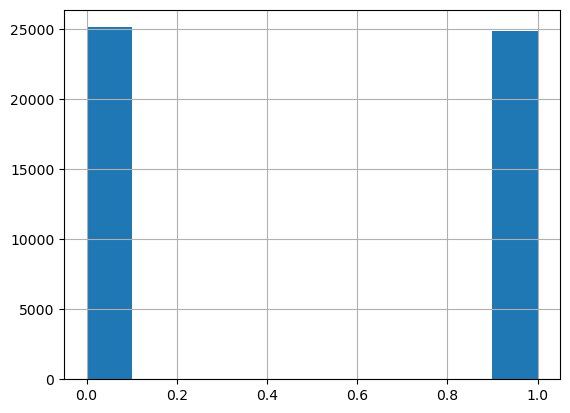

In [6]:
y.hist()

In [7]:
# Create a tokenizer to convert words to indices
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

In [93]:
tokenizer.word_index['android']

8435

In [9]:
l=[]
for review in sequences:
    l.append(len(review))

42


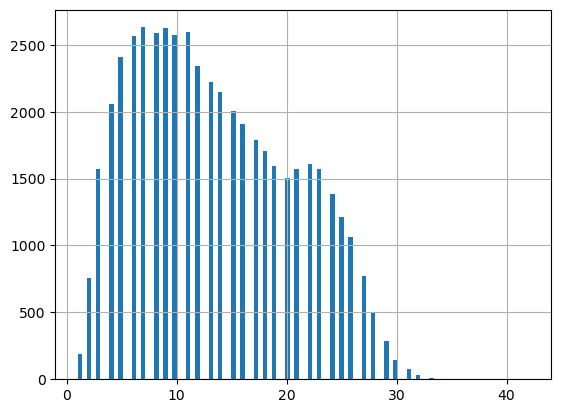

In [10]:
pd.Series(l).hist(bins=100)
print(max(l))

In [11]:
# Convert the tweets to sequences of indices
sequences = tokenizer.texts_to_sequences(X)

# Pad the sequences to a fixed length
max_len = 40
padded_sequences = pad_sequences(sequences, maxlen=max_len)


In [12]:
#print(padded_sequences)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.33, random_state=42)

In [14]:
print(len(X_test)-int(len(X)/5))

6500


In [15]:
val_size = int(len(X)/5)
test_size = len(X_test) - val_size
print('validation set size: ', val_size)
print('test set size: ', test_size)
X_val_set = X_test[:val_size]
y_val_set = y_test[:val_size]
X_test_set = X_test[val_size:]
y_test_set = y_test[val_size:]

validation set size:  10000
test set size:  6500


In [16]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=max_len))
model.add(LSTM(150))
model.add(Dense(1, activation='sigmoid'))

model.summary()


2023-05-05 17:17:19.289144: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 17:17:19.290701: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           7673984   
                                                                 
 lstm (LSTM)                 (None, 100)               91600     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 7,765,685
Trainable params: 7,765,685
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, validation_data=(X_val_set, y_val_set), epochs=5, batch_size=64, verbose=1)

Epoch 1/5
524/524 [==============================] - 96s 179ms/step - loss: 0.5279 - accuracy: 0.7356 - val_loss: 0.4805 - val_accuracy: 0.7674
Epoch 2/5
524/524 [==============================] - 95s 181ms/step - loss: 0.3311 - accuracy: 0.8607 - val_loss: 0.5463 - val_accuracy: 0.7495
Epoch 3/5
524/524 [==============================] - 94s 180ms/step - loss: 0.1751 - accuracy: 0.9336 - val_loss: 0.7164 - val_accuracy: 0.7302
Epoch 4/5
524/524 [==============================] - 94s 179ms/step - loss: 0.1032 - accuracy: 0.9611 - val_loss: 0.8069 - val_accuracy: 0.7317
Epoch 5/5
524/524 [==============================] - 92s 176ms/step - loss: 0.0698 - accuracy: 0.9737 - val_loss: 0.9991 - val_accuracy: 0.7176


In [18]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_set, y_test_set, verbose=1)

#LSTM 100, sig
#e3 b64 50,000 0.77 
#e2 b64, 50,000 0.78
#e3 b32, 50,000 0.77

#Dense 100, drop, dense 50, drop, sig

204/204 [==============================] - 7s 34ms/step - loss: 0.9758 - accuracy: 0.7260


In [88]:
search_tweet = X_test_set[5]
print(search_tweet)
s = []
for i in search_tweet:
    for x in tokenizer.word_index:
        #print(tokenizer.word_index[x])
        if i==tokenizer.word_index[x]:
            s.append(x)

print(s)

[    0     0     0     0     0     0     0     0     0     0     0     1
   166   127   251   164   114     4   287    62  1330    55   362     9
    32    83 28936    68    98     9  3065     4    82     9   376    87
     9   663    53 28937]
['i', 'hate', 'getting', 'let', 'down', 'by', 'a', 'song', 'we', 'wrote', 'u', 'put', 'it', 'out', 'there', 'optimistically', 'amp', 'hope', 'it', 'finds', 'a', 'home', 'it', 'hurts', 'when', 'it', 'comes', 'back', 'unwanted']


In [20]:
for x in tokenizer.word_index:
    if tokenizer.word_index[x] == 111:
        print(x)

he


In [21]:
print(X_test_set[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 259  25 116]


In [22]:
print(list(y_test_set))

[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 

In [23]:
for i in range(10):
    s=[]
    text = X_test_set[i]
    target = list(y_test_set)[i]

    for t in text:
        for x in tokenizer.word_index:
            #print(tokenizer.word_index[x])
            if t==tokenizer.word_index[x]:
                s.append(x)
                s.append(' ')

    tweet = "".join(map(str,s))
    tokened_text = tokenizer.texts_to_sequences(tweet)
    padded_text = pad_sequences(tokened_text, maxlen=max_len)

    pred = model.predict(padded_text)[0][0]

    print(tweet)
    print('prediction: ', pred)
    print('target: ', target)
    print()

1/1 [==============================] - 0s 334ms/step
party was fun 
prediction:  0.06373773
target:  1

2/2 [==============================] - 0s 28ms/step
bye sleeping schedule i missed you so 
prediction:  0.2333798
target:  0

4/4 [==============================] - 0s 29ms/step
fixing to take a cat nap on this rainy damp cold sunday afternoon erica i will call later this evening have a great day 
prediction:  0.6079171
target:  1

4/4 [==============================] - 0s 23ms/step
i felt awk i didn't know those kids if you normally are in an epic chat i'll go live if you wish 
prediction:  0.2760287
target:  0

3/3 [==============================] - 0s 16ms/step
it's entirely possible that my severe allergies are in fact a cold 
prediction:  0.2760287
target:  0

5/5 [==============================] - 0s 21ms/step
i hate getting let down by a song we wrote u put it out there optimistically amp hope it finds a home it hurts when it comes back unwanted 
prediction:  0.2760287
target:

In [97]:
model = tf.keras.models.load_model('sentimentAnalysisV1-em128-lstm100-sig')


In [103]:
text = [list(X_test_set[1921])]
s=[]
for t in text[0]:
    for x in tokenizer.word_index:
        #print(tokenizer.word_index[x])
        if t==tokenizer.word_index[x]:
            s.append(x)

print(s)
text = ['iphone']
tokened_text = tokenizer.texts_to_sequences(s)
padded_text = pad_sequences(tokened_text, maxlen=max_len)
pred = model.predict(padded_text)[0][0]

print(pred)

['stephenfry', 'how', 'wonderful']
1/1 [==============================] - 0s 33ms/step
0.9713018


In [95]:
model.save('sentimentAnalysisV1-em128-lstm100-sig')

INFO:tensorflow:Assets written to: sentimentAnalysisV1-em128-lstm100-sig/assets


INFO:tensorflow:Assets written to: sentimentAnalysisV1-em128-lstm100-sig/assets
